In [1]:
%matplotlib inline


In [2]:
#export
from exp.nb_05 import *

In [3]:
#export
def normalizeVectors(xTrainingVector, xValidationVector):
    return vectorNormalization(xTrainingVector), vectorNormalization(xValidationVector
                                                                    )
def vectorNormalization(vector):
    return normalizeVector(vector, vector.mean(), vector.std())

In [4]:
xTraining, yTraining, xValidation, yValidation =getMnistData()
xTrainingNormalized, xValidationNormalized = normalizeVectors(xTraining, xValidation)

Verify normalization was done correctly

In [5]:
xTrainingNormalized.mean(), xTrainingNormalized.std()

(tensor(0.0001), tensor(1.))

In [6]:
xValidationNormalized.mean(), xValidationNormalized.std()

(tensor(-4.2248e-06), tensor(1.))

## \o/
Both means are near zero and the standard deviation is near one!

In [7]:
trainingDataSet = Dataset(xTrainingNormalized.cuda(), yTraining.cuda())
validationDataSet = Dataset(xValidationNormalized.cuda(), yValidation.cuda())

In [8]:
sizeOfHiddenLayer = 50
batchSize = 64
numberOfClasses = yTraining.max().item() + 1

In [9]:
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)

In [10]:
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader,numberOfClasses)

In [11]:
imageDataBunch.numberOfClasses

10

In [12]:
#export
class LambdaLayer(torch.nn.Module):
    def __init__(self, fundie):
        super().__init__()
        self.fundie = fundie
        
    def forward(self, inputVector):
        return self.fundie(inputVector)
    
def flattenImage(imageMatrix): return imageMatrix.view(imageMatrix.shape[0], -1)

In [13]:
#export
def resizeImage(imageVector): return imageVector.view(-1, 1, 28, 28)

In [14]:
3//2

1

In [15]:

def createConvolutionLayer(inputSize, 
                           outputSize, 
                           kernelSize=3, 
                           stride=2):
    return torch.nn.Sequential(torch.nn.Conv2d(inputSize, 
                                               outputSize, 
                                               kernelSize, 
                                               stride, 
                                               kernelSize//2), torch.nn.ReLU())

In [16]:
layerSizes = [8, 16, 32, 32]
def createConvolutionModel(numberOfClasses):
    return torch.nn.Sequential(*createConvolutionLayers(numberOfClasses, layerSizes)).cuda()

In [17]:
def createConvolutionLayers(numberOfClasses, layerSizes):
    adjustedLayerSizes = [1]  + layerSizes # Make the first layer take a dimension of one
    convolutionLayers = [createConvolutionLayer(adjustedLayerSizes[i], 
                                               adjustedLayerSizes[i+1],
                                               5 if i == 0 else 3)
                        for i in range(len(adjustedLayerSizes) - 1)]
    finishingLayers = [
        torch.nn.AdaptiveAvgPool2d(1),
        LambdaLayer(flattenImage),
        torch.nn.Linear(layerSizes[-1], numberOfClasses)
    ]
    return [LambdaLayer(resizeImage)] + convolutionLayers + finishingLayers

In [18]:
convolutionModel = createConvolutionModel(numberOfClasses)
convolutionModel

Sequential(
  (0): LambdaLayer()
  (1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LambdaLayer()
  (7): Linear(in_features=32, out_features=10, bias=True)
)

In [19]:
class Teacher():
    
    def __init__(self, 
                 lossFunction=Functional.cross_entropy, 
                 accuracyFunction=accuracy,
                 schedulingFunctions=[cosineScheduler(1e-1,1e-6), cosineScheduler(1e-1,1e-6)]
                ):
        self.lossFunction = lossFunction
        self.accuracyFunction = accuracyFunction
        self.schedulingFunctions = schedulingFunctions
        self._initStorage()

    def _initStorage(self):
        self.learningRates, self.losses = [],[]
        
    def teachModel(self, cnnModel, dataBunch, numberOfEpochs):
        self.optimizer = optim.SGD(cnnModel.parameters(), self.schedulingFunctions[0](0))
        self.numberOfEpochs = numberOfEpochs
        self._beginTraining()
        for epoch in range(numberOfEpochs):
            self.epoch = epoch
            trainingLoss, trainingAccuracy = self._trainModel(cnnModel, dataBunch.trainingDataLoader)
            print("Epoch #{} Training: Loss {} Accuracy {}".format(epoch, trainingLoss, trainingAccuracy))
            
            validationLoss, validationAccuracy = self._validateModel(cnnModel, dataBunch.validationDataLoader)
            print("Epoch #{} Validation: Loss {} Accuracy {}".format(epoch, validationLoss, validationAccuracy))
            print("")
            
    def plotLearningRates  (self): plotter.plot(self.learningRates)
        
    def plotLosses(self): plotter.plot(self.losses)
            
    def _beginTraining(self):
        self._initStorage()
            
    def _anealLearningRate(self):
        for parameterGroup, schedulingFunction in zip(self.optimizer.param_groups,self.schedulingFunctions):
            scheduledLearningRate = schedulingFunction(self.epoch/self.numberOfEpochs)
            parameterGroup['lr'] = scheduledLearningRate
            
    def _trainModel(self, cnnModel, trainingDataSet):
        def _teachModel(loss):
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            #capture metrics
            self.learningRates.append(self.optimizer.param_groups[-1]['lr'])
            self.losses.append(loss.detach().cpu())
            
        returnItems = self._proccessDataSet(cnnModel, trainingDataSet, self._anealLearningRate, _teachModel)
        return returnItems
        
    def _validateModel(self, cnnModel, validationDataSet):
        with torch.no_grad():
            returnItems = self._proccessDataSet(cnnModel, validationDataSet, self._anealLearningRate)
        return returnItems
    
    def _proccessDataSet(self, 
                         cnnModel, 
                         dataLoader, 
                         preEvaluation=lambda: None,
                         postEvaluation=lambda loss: None):
        accumulatedLoss, accumulatedAccuracy = 0.,0.
        for _xDataSet, _yDataSet in dataLoader:
            preEvaluation()
            _predictions = cnnModel(_xDataSet)
            loss = self.lossFunction(_predictions, _yDataSet)
            postEvaluation(loss)
            accumulatedLoss+= loss
            accumulatedAccuracy += self.accuracyFunction(_predictions, _yDataSet)
        numberOfBatches = len(dataLoader)
        return accumulatedLoss/numberOfBatches, accumulatedAccuracy/numberOfBatches

In [20]:
phases = [0.3, 0.7]
weightsScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.3, 0.6, 0.2)) 
biasScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.9, 1.8, 0.6))

In [21]:
steps = torch.arange(0, 100)
inputSpace = torch.linspace(0.01,1,100)

In [22]:
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

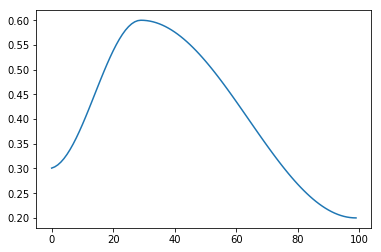

In [23]:
plotter.plot(steps, [weightsScheduler(o) for o in inputSpace])

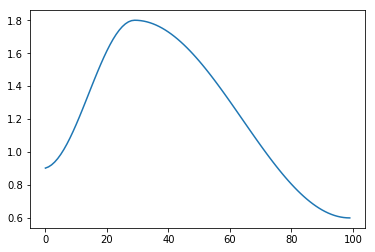

In [24]:
plotter.plot(steps, [biasScheduler(o) for o in inputSpace])

In [25]:
teacher = Teacher(schedulingFunctions=[weightsScheduler, biasScheduler])

In [26]:
%time teacher.teachModel(convolutionModel, imageDataBunch, 3)

Epoch #0 Training: Loss 0.4566411077976227 Accuracy 0.8456282019615173
Epoch #0 Validation: Loss 0.20365390181541443 Accuracy 0.9367088675498962

Epoch #1 Training: Loss 0.149496391415596 Accuracy 0.9547234773635864
Epoch #1 Validation: Loss 0.09270259737968445 Accuracy 0.9718157052993774

Epoch #2 Training: Loss 0.06801427900791168 Accuracy 0.9797993898391724
Epoch #2 Validation: Loss 0.15421360731124878 Accuracy 0.9564873576164246

CPU times: user 8.41 s, sys: 748 ms, total: 9.16 s
Wall time: 9.15 s


In [27]:
accuracy(convolutionModel(xValidationNormalized.cuda()), yValidation.cuda())

tensor(0.9560, device='cuda:0')

## Pytorch Hooks

In [15]:
#export
class TeacherWithHooks():
    
    
    def __init__(self, 
                 lossFunction=Functional.cross_entropy, 
                 accuracyFunction=accuracy,
                 schedulingFunctions=[cosineScheduler(1e-1,1e-6), cosineScheduler(1e-1,1e-6)]
                ):
        self.lossFunction = lossFunction
        self.accuracyFunction = accuracyFunction
        self.schedulingFunctions = schedulingFunctions
        self._initStorage()

    def _initStorage(self):
        self.learningRates, self.losses = [],[]
        self.registeredHooks = []
        
    def teachModel(self, cnnModel, dataBunch, numberOfEpochs):
        self.optimizer = optim.SGD(cnnModel.parameters(), self.schedulingFunctions[0](0))
        self.numberOfEpochs = numberOfEpochs
        self.modelsMeans = [[] for _ in cnnModel]
        self.convolutionModel = cnnModel
        self.modelsStandardDeviations = [[] for _ in cnnModel]
        self._beginTraining()
        for epoch in range(numberOfEpochs):
            self.epoch = epoch
            trainingLoss, trainingAccuracy = self._trainModel(cnnModel, dataBunch.trainingDataLoader)
            print("Epoch #{} Training: Loss {} Accuracy {}".format(epoch, trainingLoss, trainingAccuracy))
            
            validationLoss, validationAccuracy = self._validateModel(cnnModel, dataBunch.validationDataLoader)
            print("Epoch #{} Validation: Loss {} Accuracy {}".format(epoch, validationLoss, validationAccuracy))
            print("")
            
    def plotLearningRates  (self): plotter.plot(self.learningRates)
        
    def plotLosses(self): plotter.plot(self.losses)
        
    def plotMeans(self):
        for layerOutputMeans in self.modelsMeans: plotter.plot(layerOutputMeans[:200])
        plotter.legend(range(len(self.modelsMeans)))
        
    def plotStandardDeviations(self):
        for layerOutputSD in self.modelsStandardDeviations: plotter.plot(layerOutputSD[:200])
        plotter.legend(range(len(self.modelsStandardDeviations)))
            
    def _beginTraining(self):
        self._initStorage()
      
    def _addStats(self, index, model, inputParameters, outputParameters):
        self.modelsMeans[index].append(outputParameters.data.mean())
        self.modelsStandardDeviations[index].append(outputParameters.data.std())
    
    def _registerHooks(self):
        for index, modelLayer in enumerate(self.convolutionModel):
            self.registeredHooks.append(modelLayer.register_forward_hook(partial(self._addStats, index)))
        
    def _unregisterHooks(self):
        for registeredHooks in self.registeredHooks: registeredHooks.remove()
        self.registeredHooks = []
            
    def _anealLearningRate(self):
        for parameterGroup, schedulingFunction in zip(self.optimizer.param_groups,self.schedulingFunctions):
            scheduledLearningRate = schedulingFunction(self.epoch/self.numberOfEpochs)
            parameterGroup['lr'] = scheduledLearningRate
            
    def _trainModel(self, cnnModel, trainingDataSet):
        def _teachModel(loss):
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            #capture metrics
            self.learningRates.append(self.optimizer.param_groups[-1]['lr'])
            self.losses.append(loss.detach().cpu())
            
        returnItems = self._proccessDataSet(cnnModel, 
                                            trainingDataSet, 
                                            preEpoch=self._registerHooks,
                                            preEvaluation=self._anealLearningRate, 
                                            postEpoch=self._unregisterHooks,
                                            postEvaluation=_teachModel
                                           )
        return returnItems
        
    def _validateModel(self, cnnModel, validationDataSet):
        with torch.no_grad():
            returnItems = self._proccessDataSet(cnnModel, validationDataSet)
        return returnItems
    
    def _proccessDataSet(self, 
                         cnnModel, 
                         dataLoader, 
                         preEpoch=lambda: None,
                         preEvaluation=lambda: None,
                         postEvaluation=lambda loss: None,
                         postEpoch=lambda: None
                        ):
        accumulatedLoss, accumulatedAccuracy = 0.,0.
        preEpoch()
        for _xDataSet, _yDataSet in dataLoader:
            preEvaluation()
            _predictions = cnnModel(_xDataSet)
            loss = self.lossFunction(_predictions, _yDataSet)
            postEvaluation(loss)
            accumulatedLoss+= loss
            accumulatedAccuracy += self.accuracyFunction(_predictions, _yDataSet)
        postEpoch()
        numberOfBatches = len(dataLoader)
        return accumulatedLoss/numberOfBatches, accumulatedAccuracy/numberOfBatches

NameError: name 'Functional' is not defined

In [93]:
def createModelAndTeacher():
    return createConvolutionModel(numberOfClasses), TeacherWithHooks(schedulingFunctions=[weightsScheduler, biasScheduler])

In [94]:
convolutionModelSR1, teacherSR1 = createModelAndTeacher()

In [55]:
teacherSR1.teachModel(convolutionModelSR1, imageDataBunch, 1)

Epoch #0 Training: Loss 0.48893436789512634 Accuracy 0.8403133153915405
Epoch #0 Validation: Loss 0.1096002385020256 Accuracy 0.9676622152328491



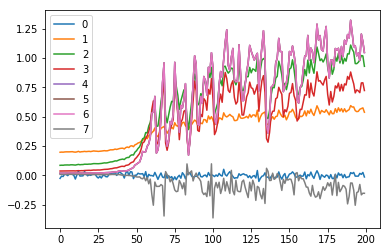

In [50]:
teacherSR1.plotMeans()

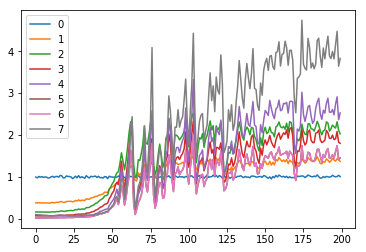

In [57]:
teacherSR1.plotStandardDeviations()

In [11]:
#export
class GeneralRectifiedLinearUnit(torch.nn.Module):
    def __init__(self, leaky=None, subtractValue=0, maxToClamp=math.inf):
        super().__init__()
        self.leaky, self.subtractValue, self.maxToClamp = leaky, subtractValue, maxToClamp
        
    def forward(self, inputVector):
        rectifiedVector = \
            Functional.leaky_relu(inputVector, self.leaky) \
                if self.leaky is not None \
                else Functional.relu(inputVector)
        if self.subtractValue > 0: rectifiedVector.sub_(self.subtractValue)
        if self.maxToClamp is not math.inf: rectifiedVector.clamp_max_(self.maxToClamp)
        return rectifiedVector
        

NameError: name 'torch' is not defined

In [12]:
#export
layerSizes = [8, 16, 32, 32]

def createBetterConvolutionModel(numberOfClasses, layerSizes):
    return torch.nn.Sequential(*createBetterConvolutionLayers(numberOfClasses, layerSizes))

def createBetterConvolutionalLayer(inputSize, 
                                   outputSize, 
                                   kernelSize=3, 
                                   stride=2,
                                   leaky=0.1,
                                   subtractValue=0.4,
                                   maxToClamp=6.0
                                  ):
    return torch.nn.Sequential(torch.nn.Conv2d(inputSize, 
                                               outputSize, 
                                               kernelSize, 
                                               stride, 
                                               kernelSize//2), 
                               GeneralRectifiedLinearUnit(leaky, 
                                                          subtractValue, 
                                                          maxToClamp))


def createBetterConvolutionLayers(numberOfClasses, layerSizes):
    adjustedLayerSizes = [1]  + layerSizes # Make the first layer take a dimension of one
    convolutionLayers = [createBetterConvolutionalLayer(adjustedLayerSizes[i], 
                                               adjustedLayerSizes[i+1],
                                               5 if i == 0 else 3)
                        for i in range(len(adjustedLayerSizes) - 1)]
    finishingLayers = [
        torch.nn.AdaptiveAvgPool2d(1),
        LambdaLayer(flattenImage),
        torch.nn.Linear(layerSizes[-1], numberOfClasses)
    ]
    return [LambdaLayer(resizeImage)] + convolutionLayers + finishingLayers

In [101]:
def kaimingInitializeLayers(modelToInitialize):
    for modelLayer in modelToInitialize:
        if isinstance(modelLayer, torch.nn.Sequential):
            init.kaiming_normal_(modelLayer[0].weight, a=0.1)
            modelLayer[0].bias.data.zero_()

In [102]:
_, teacherSR2 = createModelAndTeacher()

In [103]:
convolutionModelSR2 = createBetterConvolutionModel(numberOfClasses, layerSizes)
convolutionModelSR2

Sequential(
  (0): LambdaLayer()
  (1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LambdaLayer()
  (7): Linear(in_features=32, out_features=10, bias=True)
)

In [104]:
kaimingInitializeLayers(convolutionModelSR2)

In [105]:
teacherSR2.teachModel(convolutionModelSR2, imageDataBunch, 3)

Epoch #0 Training: Loss 0.31766659021377563 Accuracy 0.8989570140838623
Epoch #0 Validation: Loss 0.11555308848619461 Accuracy 0.9671677350997925

Epoch #1 Training: Loss 0.257575660943985 Accuracy 0.9243525862693787
Epoch #1 Validation: Loss 0.15653792023658752 Accuracy 0.9556962251663208

Epoch #2 Training: Loss 0.07813160121440887 Accuracy 0.9755834341049194
Epoch #2 Validation: Loss 0.06523832678794861 Accuracy 0.9825949668884277



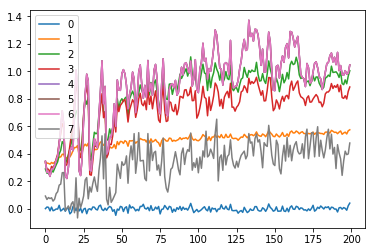

In [106]:
teacherSR2.plotMeans()

In [13]:
#export
from IPython.display import display, Javascript
def exportNotebook():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
exportNotebook()